In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from glob import glob
import os

In [95]:
from tensorflow.keras.layers import Input, Lambda, Flatten, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications import vgg16, InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

In [96]:
import random

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [97]:
# IRO TFA CCFE

In [98]:
IMAGE_SIZE = [224, 224]

In [99]:
vgg19 = VGG19(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)

In [100]:
# dont train the existing weights
for layer in vgg19.layers:
    layer.trainable = False

In [101]:
# useful for getting number of output classes
folders = glob('geological_similarity/*')
folders

['geological_similarity\\andesite',
 'geological_similarity\\gneiss',
 'geological_similarity\\marble',
 'geological_similarity\\quartzite',
 'geological_similarity\\rhyolite',
 'geological_similarity\\schist']

In [102]:
# Converting images to dataframe to process it
def data_prep(andesite, gneiss, marble, quartzite, rhyolite, schist):

    andesite = ["geological_similarity/andesite" + '/' +  a for a in andesite]
    gneiss = ["geological_similarity/gneiss" + '/' +  b for b in gneiss]
    marble = ["geological_similarity/marble" + '/' +  c for c in marble]
    quartzite = ["geological_similarity/quartzite" + '/' +  d for d in quartzite]
    rhyolite = ["geological_similarity/rhyolite" + '/' +  e for e in rhyolite]
    schist = ["geological_similarity/schist" + '/' +  f for f in schist]

    labels = len(andesite)*['andesite'] + len(gneiss)*['gneiss'] + len(marble)*['marble'] + len(quartzite)*['quartzite'] + len(rhyolite)*['rhyolite'] + len(schist)*['schist']
    data = andesite + gneiss + marble + quartzite + rhyolite + schist

    return pd.DataFrame({'Image_Path': data , 'Labels': labels})


df = data_prep(os.listdir('geological_similarity/andesite/'), os.listdir('geological_similarity/gneiss/'), os.listdir('geological_similarity/marble/'), os.listdir('geological_similarity/quartzite/'), os.listdir('geological_similarity/rhyolite/'), os.listdir('geological_similarity/schist/'))
df

,Image_Path,Labels
0,geological_similarity/andesite/012L6.jpg,andesite
1,geological_similarity/andesite/01ITR.jpg,andesite
2,geological_similarity/andesite/01LQQ.jpg,andesite
3,geological_similarity/andesite/0230P.jpg,andesite
4,geological_similarity/andesite/02741.jpg,andesite
...,...,...
29993,geological_similarity/schist/ZYMEE.jpg,schist
29994,geological_similarity/schist/ZYRT4.jpg,schist
29995,geological_similarity/schist/ZZ4TJ.jpg,schist
29996,geological_similarity/schist/ZZ5Z5.jpg,schist


Text(0.5, 1.0, 'Distribution of samples according to the categories')

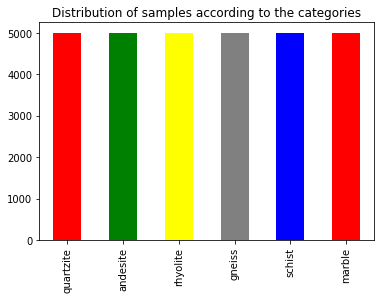

In [103]:
df['Labels'].value_counts().plot(kind = 'bar', color = ['red', 'green', 'yellow', 'grey', 'blue'])
plt.title('Distribution of samples according to the categories')

In [104]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=1)

In [105]:
test.shape

(6000, 2)

In [106]:
# Time for data augmentation

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [107]:
x_train =  train_datagen.flow_from_dataframe(dataframe = train,  x_col='Image_Path', y_col='Labels',  class_mode='categorical',target_size=(224,224), shuffle=False, batch_size=10, seed=10)
x_test = test_datagen.flow_from_dataframe(dataframe = test,  x_col='Image_Path', y_col='Labels',class_mode='categorical',  target_size=(224,224), shuffle=False, batch_size=10, seed=10)
len(x_train), len(x_test)

Found 23998 validated image filenames belonging to 6 classes.
Found 6000 validated image filenames belonging to 6 classes.


(2400, 600)

In [108]:
# Lets make the CNN for this
# Create CNN

import tensorflow as tf
model = tf.keras.Sequential(
        [
          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(224,224,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(224,224,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(224,224,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(224,224,3) ,filters=64, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(rate=0.5),
          tf.keras.layers.Dense(6, activation='sigmoid')
  ])

In [109]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [110]:
model_history = model.fit_generator(generator = x_train, 
                   steps_per_epoch = 100,
                   epochs = 1 ,
                   validation_data = x_test,
                   validation_steps = 100)


C:\Users\rohan\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


100/100 [==============================] - 11s 105ms/step - loss: 1.3753 - accuracy: 0.4040 - val_loss: 0.7395 - val_accuracy: 0.6450


In [111]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)       

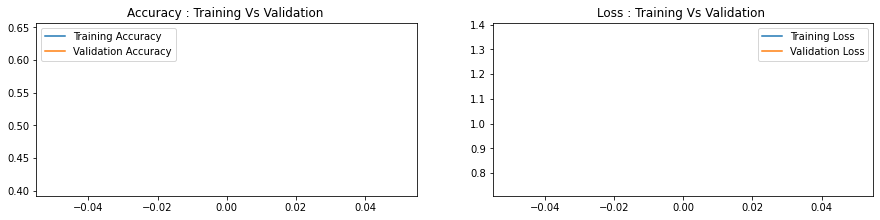

In [112]:

accuracy = model_history.history['accuracy']
loss = model_history.history['loss']
validation_loss = model_history.history['val_loss']
validation_accuracy = model_history.history['val_accuracy']



plt.figure(figsize=(15, 7))
plt.subplot(2, 2, 1)
plt.plot(range(len(accuracy)), accuracy, label='Training Accuracy')
plt.plot(range(len(accuracy)), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy : Training Vs Validation ')



plt.subplot(2, 2, 2)
plt.plot(range(len(accuracy)), loss, label='Training Loss')
plt.plot(range(len(accuracy)), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.legend(loc='upper right')
plt.show()


In [113]:
# Image embedding
# def get_embedding(file, model):
#     image = mpimg.imread(file)
#     image = test_transform(image)
#     image = image.unsqueeze(0)
#     model.eval()
#     with torch.no_grad():
#         emb, _ = model(image)
#     return emb.numpy()

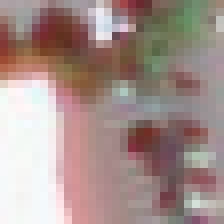

In [114]:
from tensorflow.keras.preprocessing import image
img1=image.load_img('../Geological Similarity Amazon/geological_similarity/gneiss/01RNW.jpg',target_size=(224,224,3))
img2=image.load_img('../Geological Similarity Amazon/geological_similarity/gneiss/0THX1.jpg',target_size=(224,224,3))
img1 

In [115]:
image.img_to_array(img2).reshape(50176, 3).shape

(50176, 3)

In [116]:
sim = cosine_similarity(
    model.predict(preprocess_input(np.expand_dims(image.img_to_array(img1), axis=0))),
    model.predict(preprocess_input(np.expand_dims(image.img_to_array(img2), axis=0)))
)
sim[0]

array([0.8944272], dtype=float32)

In [117]:
df['Image_Path'][:5]

0    geological_similarity/andesite/012L6.jpg
1    geological_similarity/andesite/01ITR.jpg
2    geological_similarity/andesite/01LQQ.jpg
3    geological_similarity/andesite/0230P.jpg
4    geological_similarity/andesite/02741.jpg
Name: Image_Path, dtype: object

In [257]:
imagess = []
for img in df['Image_Path'][:10]:

    imgx = image.load_img('../Geological Similarity Amazon/' + img,target_size=(224,224,3))
    
    similarities = cosine_similarity(model.predict(preprocess_input(np.expand_dims(image.img_to_array(img1), axis=0))), model.predict(preprocess_input(np.expand_dims(image.img_to_array(imgx), axis=0))))
    imagess.append(similarities)
#     break
len(imagess)

10

In [258]:
df1 = df.head(10)
df1['Similarity'] = imagess
df1['Similarity'] = df1['Similarity'].astype(float)
df1['Similarity'].idxmax()

<ipython-input-258-9b28ec7a857b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Similarity'] = imagess
<ipython-input-258-9b28ec7a857b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Similarity'] = df1['Similarity'].astype(float)


6

In [259]:
df1 = df1.sort_values('Similarity', ascending=False)
df1

,Image_Path,Labels,Similarity
6,geological_similarity/andesite/02UT8.jpg,andesite,0.902393
0,geological_similarity/andesite/012L6.jpg,andesite,0.894427
2,geological_similarity/andesite/01LQQ.jpg,andesite,0.894427
3,geological_similarity/andesite/0230P.jpg,andesite,0.894427
5,geological_similarity/andesite/02Q0N.jpg,andesite,0.894427
7,geological_similarity/andesite/02V0N.jpg,andesite,0.894427
8,geological_similarity/andesite/031XF.jpg,andesite,0.894427
9,geological_similarity/andesite/03GPU.jpg,andesite,0.894427
1,geological_similarity/andesite/01ITR.jpg,andesite,0.774597
4,geological_similarity/andesite/02741.jpg,andesite,0.774597


In [264]:
for i in df1['Image_Path'][:5]:
    df1['Image_Path'][i]

SyntaxError: unexpected EOF while parsing (<ipython-input-264-d3ce082b5fd3>, line 2)

In [242]:
df1['Image_Path'][df1['Similarity'].idxmax()]

'geological_similarity/andesite/02UT8.jpg'

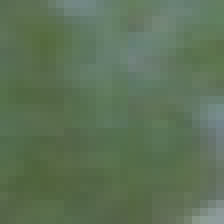

In [244]:
show_img = image.load_img('../Geological Similarity Amazon/' + df1['Image_Path'][df1['Similarity'].idxmax()],target_size=(224,224,3))
show_img